# Usando NN para modelar os dados

> Jean Cardoso, Ph.D.

## Instalando pacotes

In [72]:
# Carregando o notebook externo
!pip install -q import-ipynb
!pip install -q boruta
!pip install -q mrmr-selection
!pip install -q optuna
!pip install -q tensorflow

In [74]:
import import_ipynb

#from google.colab import drive
#drive.mount('/content/drive')

# Caminho para o notebook `features.ipynb` no Google Drive
notebook_path = '/content/drive/MyDrive/case_rentcars/case_rentcars/modeling/train_NN.ipynb'

In [75]:
# Importando as funções do notebook
import nbformat
from nbconvert import PythonExporter

with open(notebook_path) as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
source, _ = exporter.from_notebook_node(nb)
exec(source)

In [76]:
# Importando pacotes
import pandas as pd
import numpy as np
import json
import os
import pickle
import joblib
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy
import optuna
from optuna import create_study
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import ks_2samp
import mrmr
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, log_loss, precision_score, recall_score, f1_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Importando dados

In [77]:
# Carregando dados de treino
df = pd.read_parquet('/content/drive/MyDrive/case_rentcars/data/processed/data_train.parquet')
print(df.shape)
df.head()

(1384617, 32)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,user_hour_order_freq,user_dow_order_freq,user_avg_days_since_prior,user_days_since_last_order,product_popularity,user_product_popularity,product_avg_days_since_prior,product_order_freq,product_reorder_ratio,avg_pos_incart
0,1187899,1,train,11,4,8,14.0,196,1,1,...,14,9,18.542374,30.0,35791.0,4.473875,11.195804,35791.0,0.776480,3.721774
1,1187899,1,train,11,4,8,14.0,25133,2,1,...,14,9,18.542374,30.0,6196.0,3.848447,9.564880,6196.0,0.740155,7.001614
2,1187899,1,train,11,4,8,14.0,38928,3,1,...,14,9,18.542374,30.0,13238.0,5.806140,9.666038,13238.0,0.827769,3.487309
3,1187899,1,train,11,4,8,14.0,26405,4,1,...,14,9,18.542374,30.0,1214.0,1.790560,14.831961,1214.0,0.441516,3.116969
4,1187899,1,train,11,4,8,14.0,39657,5,1,...,14,9,18.542374,30.0,5019.0,4.278772,10.549313,5019.0,0.766288,4.081491


In [78]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_train.shape, df_test.shape

((969231, 32), (415386, 32))

In [79]:
df_train['is_test'] = 0
df_test['is_test'] = 1

data_model = pd.concat([df_train, df_test])
data_model.shape

(1384617, 33)

In [80]:
list(data_model.columns)

['order_id',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'user_order_count',
 'user_avg_products_per_order',
 'user_unique_products',
 'user_reorder_ratio',
 'user_avg_days_between_orders',
 'user_reorder_rate',
 'user_reorder_freq',
 'user_reordered_products_ratio',
 'order_dow_sin',
 'order_dow_cos',
 'order_hour_of_day_sin',
 'order_hour_of_day_cos',
 'user_hour_order_freq',
 'user_dow_order_freq',
 'user_avg_days_since_prior',
 'user_days_since_last_order',
 'product_popularity',
 'user_product_popularity',
 'product_avg_days_since_prior',
 'product_order_freq',
 'product_reorder_ratio',
 'avg_pos_incart',
 'is_test']

In [81]:
target = 'reordered'
cols_var = ['user_order_count',
            'user_avg_products_per_order',
            'user_unique_products',
            'user_reorder_ratio',
            'user_avg_days_between_orders',
            'user_reorder_rate',
            'user_reorder_freq',
            'user_reordered_products_ratio',
            'order_dow_sin',
            'order_dow_cos',
            'order_hour_of_day_sin',
            'order_hour_of_day_cos',
            'user_hour_order_freq',
            'user_dow_order_freq',
            'user_avg_days_since_prior',
            'user_days_since_last_order',
            'product_popularity',
            'user_product_popularity',
            'product_avg_days_since_prior',
            'product_order_freq',
            'product_reorder_ratio',
            'avg_pos_incart']
cols_cat = []

## Modelagem NN

Epoch 1/50
15145/15145 [==============================] - 69s 5ms/step - loss: 0.5836 - accuracy: 0.6957 - val_loss: 0.5727 - val_accuracy: 0.7051
Epoch 2/50
15145/15145 [==============================] - 69s 5ms/step - loss: 0.5790 - accuracy: 0.6993 - val_loss: 0.5730 - val_accuracy: 0.7054
Epoch 3/50
15145/15145 [==============================] - 71s 5ms/step - loss: 0.5786 - accuracy: 0.6995 - val_loss: 0.5667 - val_accuracy: 0.7051
Epoch 4/50
15145/15145 [==============================] - 73s 5ms/step - loss: 0.5782 - accuracy: 0.7002 - val_loss: 0.5675 - val_accuracy: 0.7053
Epoch 5/50
15145/15145 [==============================] - 71s 5ms/step - loss: 0.5783 - accuracy: 0.7005 - val_loss: 0.5701 - val_accuracy: 0.7041
Epoch 6/50
15145/15145 [==============================] - 76s 5ms/step - loss: 0.5782 - accuracy: 0.7004 - val_loss: 0.5715 - val_accuracy: 0.7051
Epoch 7/50
15145/15145 [==============================] - 71s 5ms/step - loss: 0.5781 - accuracy: 0.7005 - val_loss: 0

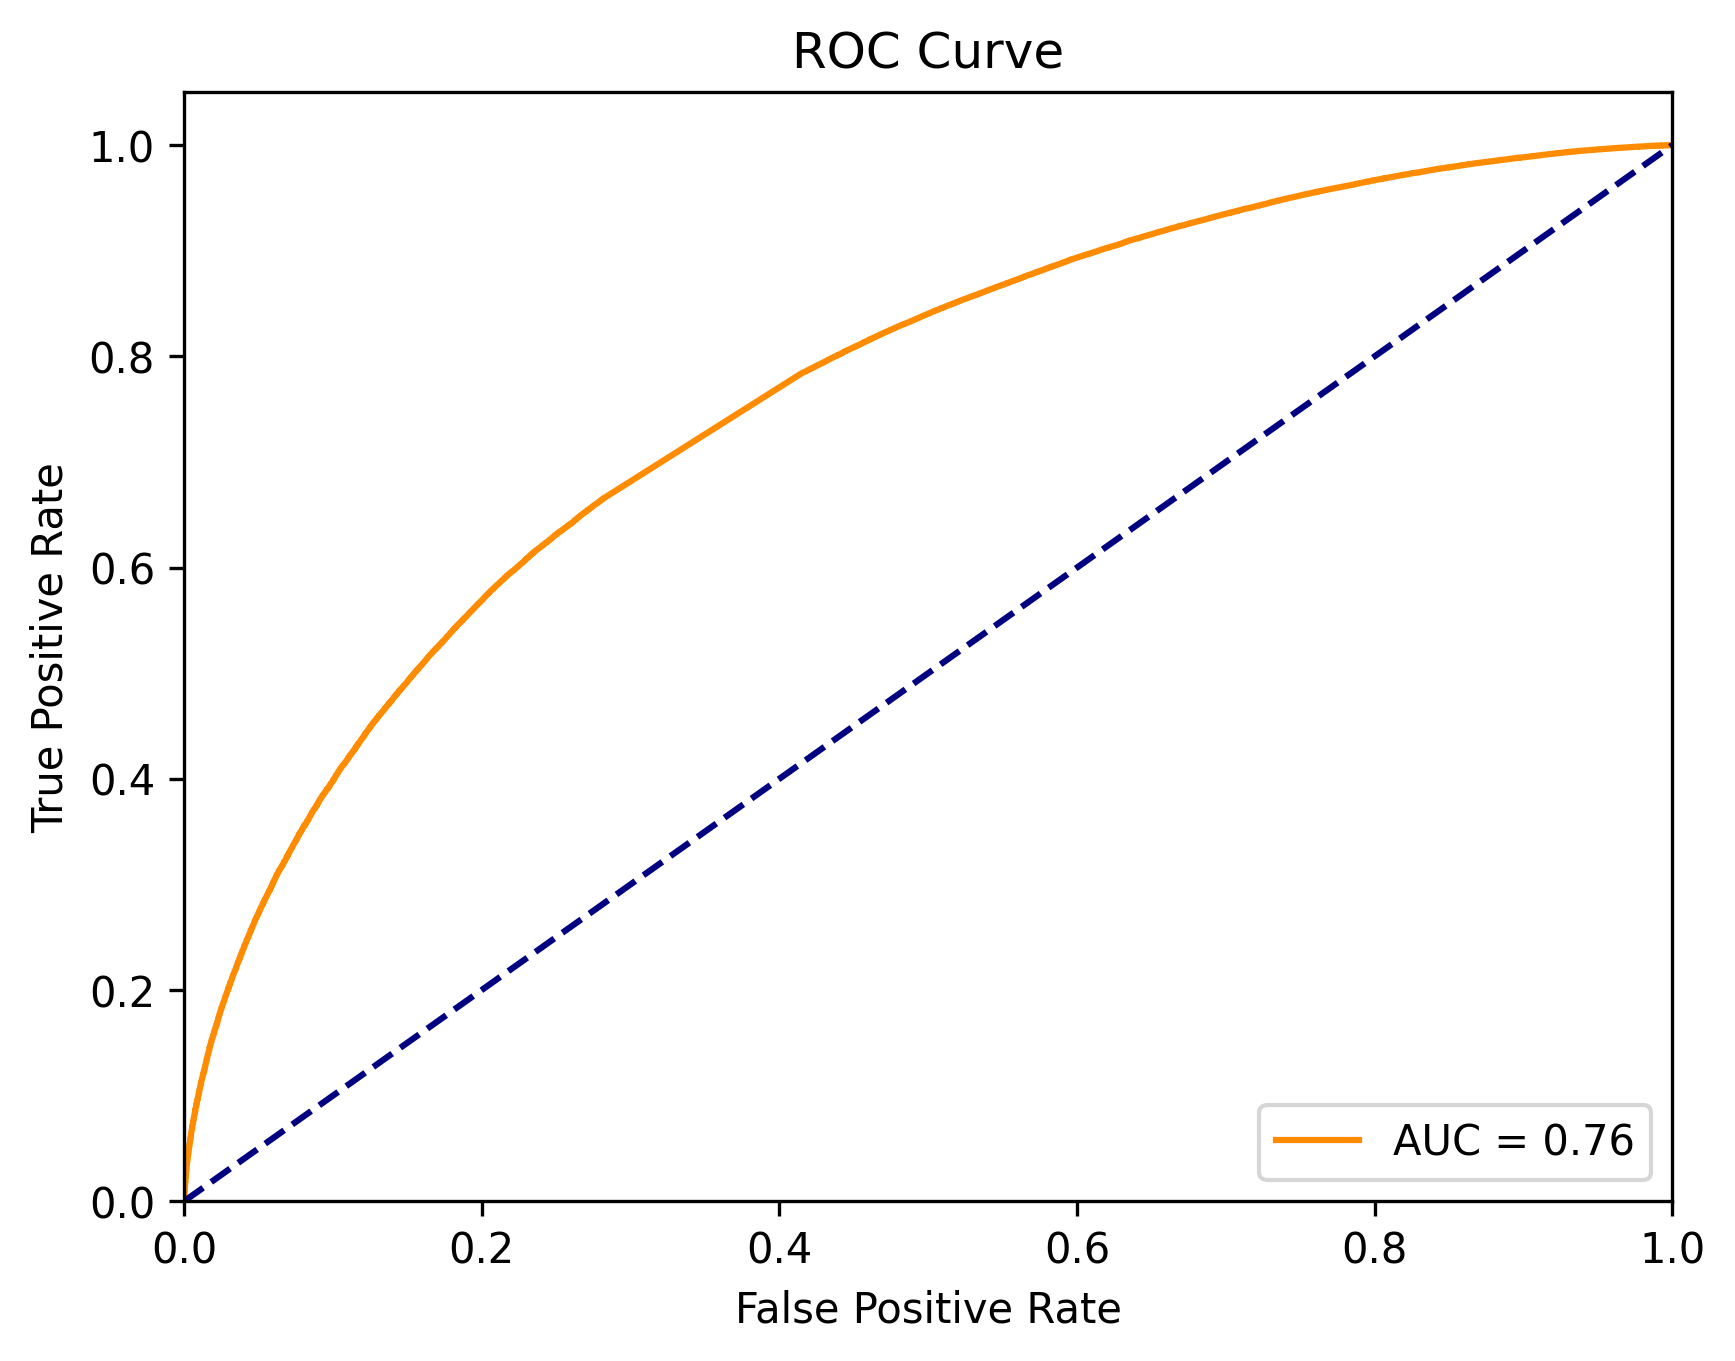

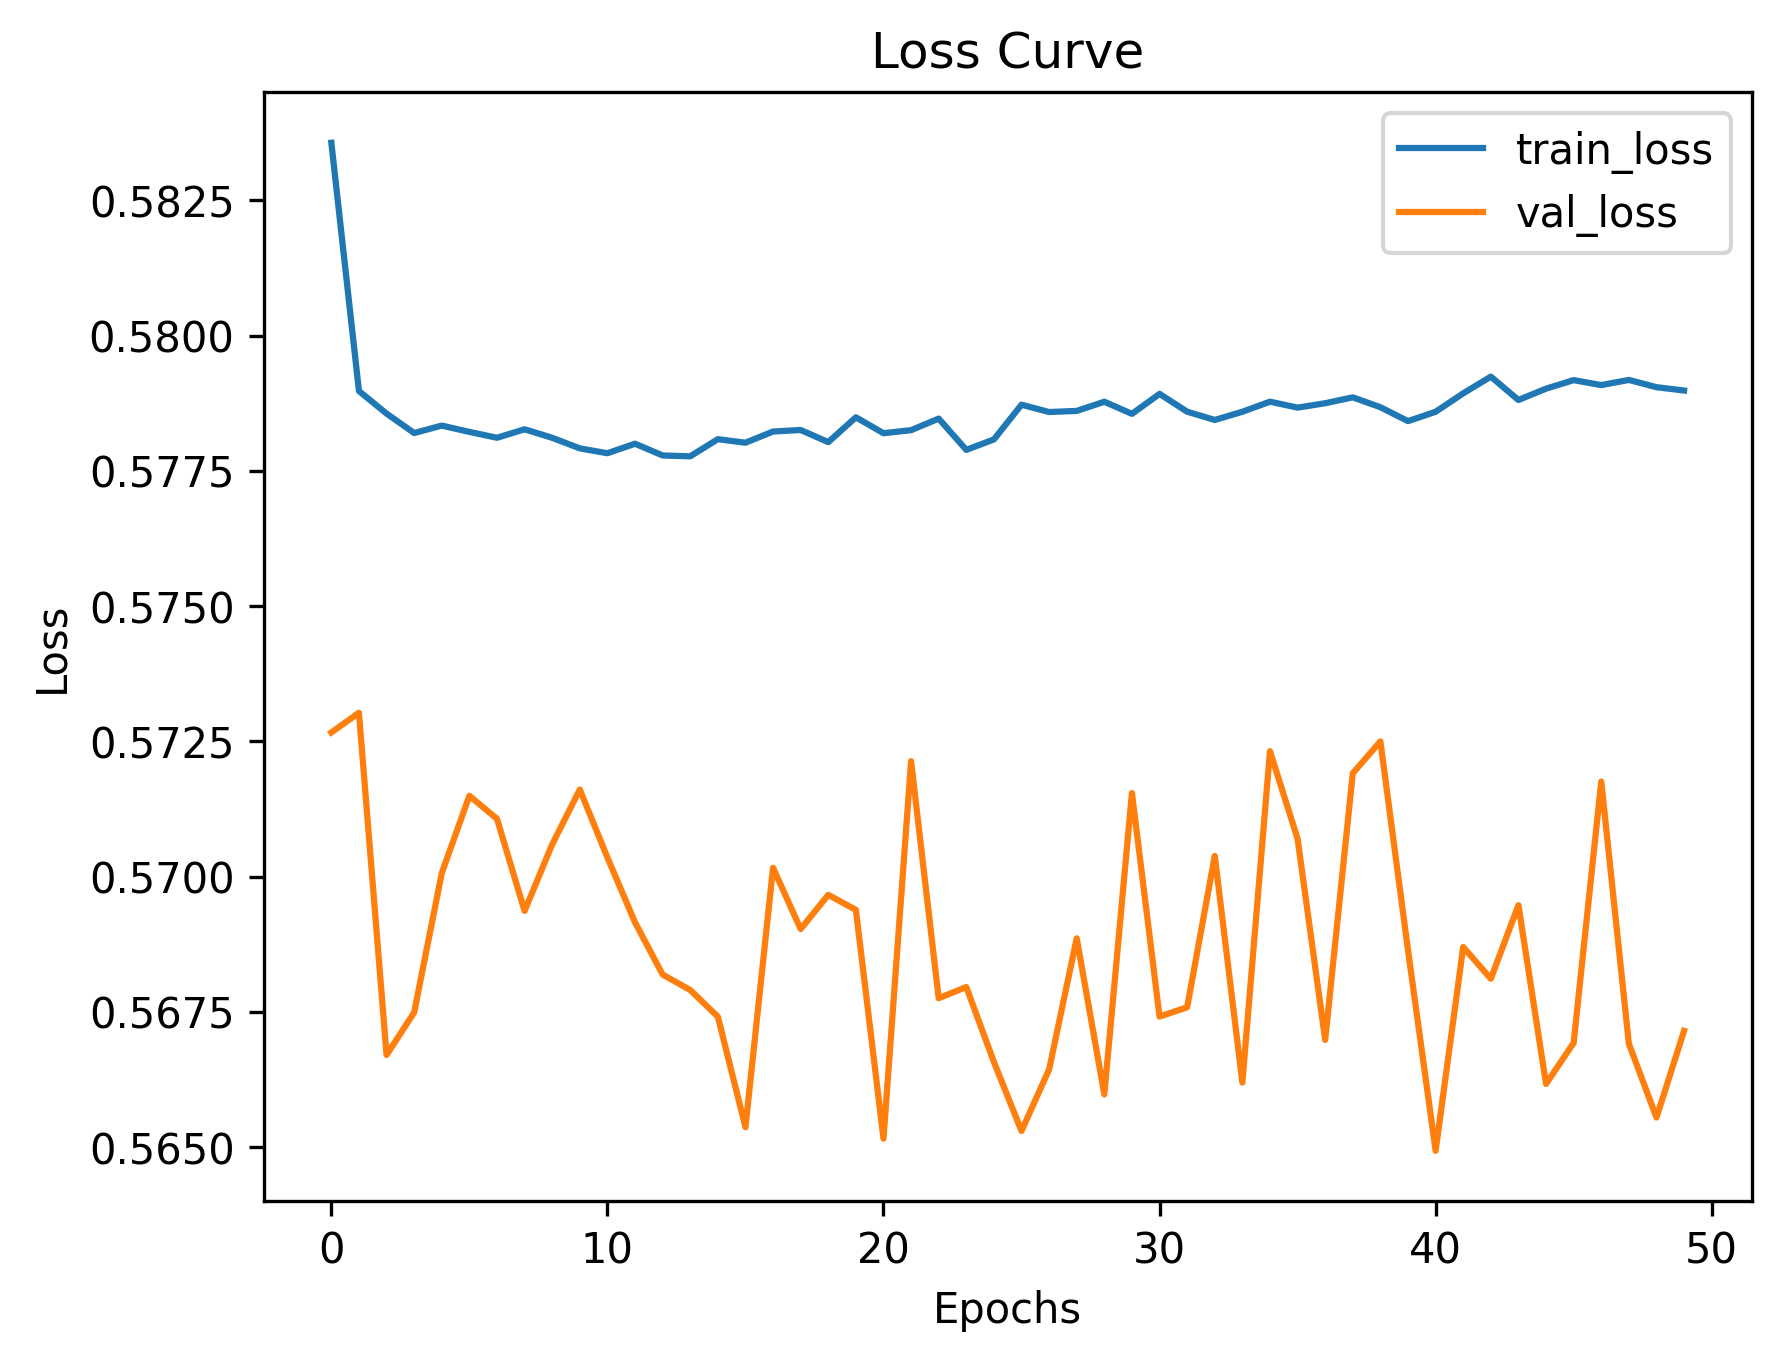

CPU times: user 1h 40min 24s, sys: 13min 57s, total: 1h 54min 21s
Wall time: 1h 7min 1s


In [82]:
%%time
# Instanciar o modelo
model_NN_ = SimplifiedNNModel(
    data=data_model,
    features=cols_var,
    target=target,
    test_flag_label="is_test",
    test_size=0.3,
    random_state=42,
    epochs=50,
    batch_size=64,
    learning_rate=0.001,
    scaling_method='standard'  # Padronização,
)

# Rodar o modelo
model_NN_.run()

In [83]:
# Prever os dados de teste
probabilities, binary_predictions = model_NN_.predict(pd.DataFrame(model_NN_.X_test, columns=model_NN_.features))

# Calcular a métrica do Kaggle
results_df = pd.DataFrame({
    'user_id': model_NN_.data[model_NN_.data['is_test'] == 1]['user_id'].values,
    'y_true': model_NN_.y_test,
    'y_pred': binary_predictions.flatten()  # Converte previsões para formato correto
})

# Calculando a métrica Kaggle
f1_kaggle = instacart_f1_score(results_df, 'user_id', 'y_true', 'y_pred')
print(f"F1 Score Kaggle: {f1_kaggle:.4f}")

12981/12981 [==============================] - 20s 2ms/step
F1 Score Kaggle: 0.6348


## Salvando os resultados

In [ ]:
# Especificar o diretório onde as informações serão salvas
#directory_path = '/content/drive/MyDrive/case_rentcars/models'
# Salvar todas as informações importantes
#save_model_info(model_NN_, base_path=directory_path)